<a href="https://colab.research.google.com/github/sabeesh90/Layer_Fine_Tuning_Deep_Neural_Networks/blob/main/The_Lazarus_Trials_DenseNet121_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importing libraries

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import seaborn as sns
import warnings
import os
from skimage import io
import pathlib
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix
!pip install -q -U keras-tuner
import kerastuner as kt
%load_ext tensorboard
warnings.filterwarnings("ignore")


     |████████████████████████████████| 96 kB 5.4 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [ ]:
pip install Ipython

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
classes = ['GALAXY', 'QSO', 'STAR']

In [ ]:
def generate_graph(model_training):
    plt.figure(figsize= (15,5))
    plt.subplot(1,2,1)
    plt.plot(model_training.history.history['accuracy'])
    plt.plot(model_training.history.history['val_accuracy'])
    plt.title('Training vs TestAccuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.subplot(1,2,2)
    plt.plot(model_training.history.history['loss'])
    plt.plot(model_training.history.history['val_loss'])
    plt.title('Training loss vs Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.show()

class Metrics:
    # from sklearn
    def __init__(self, model, val_ds):
        self.val_ds = val_ds
        self.model = model
        self.prediction_classes = np.array([])
        self.true_classes = np.array([])
        
    def calculate_scores(self):     
        print('calculating score.....')   
        
        for x, y in self.val_ds:
            self.prediction_classes = np.concatenate([self.prediction_classes,np.argmax(self.model.predict(x), axis = -1)])
            self.true_classes = np.concatenate([self.true_classes, np.argmax(y.numpy(), axis=-1)])
        
        class_report = classification_report(self.true_classes, self.prediction_classes)
        conf_matrix = confusion_matrix(self.true_classes, self.prediction_classes)
        print(conf_matrix)
        print('------------------------------------')
        print(class_report)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

#### Densenet 121

##### Data preparation

In [ ]:
# Preprocessing the data
dataset_path = 'Images'
img_width = 512
img_height = 512
channels = 3
num_classes = 3
batch_size = 8


img_width_crop = 1024
img_height_crop = 1024

rescale = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])


# augmenting the data
# cropless flip and rotate

data_aug_flip = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                # layers.experimental.preprocessing.RandomRotation(0.2)])
])

data_aug_flip_rotate = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                layers.experimental.preprocessing.RandomRotation(0.2)])


# crop flip and rotate
data_aug_crop_flip_rotate = tf.keras.Sequential([layers.experimental.preprocessing.CenterCrop(512,512),
                                                 layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                                 layers.experimental.preprocessing.RandomRotation(0.2)])

data_aug_crop_flip = tf.keras.Sequential([layers.experimental.preprocessing.CenterCrop(512,512),
                                          layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")])

normal_crop = tf.keras.Sequential([layers.experimental.preprocessing.CenterCrop(512,512)],)
batch_size =32 
autotune = tf.data.AUTOTUNE

# Preparing the normal dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'training',seed = 123, image_size = (img_width, img_height), 
                                                                  batch_size = batch_size, label_mode = 'categorical',)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'validation',seed = 123, image_size = (img_width, img_height),
                                                                batch_size = batch_size, label_mode = 'categorical')

train_ds_cropped = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'training',seed = 123, image_size = (img_width_crop, img_height_crop), 
                                                                  batch_size = batch_size, label_mode = 'categorical',)
val_ds_cropped = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'validation',seed = 123, image_size = (img_width_crop, img_height_crop),
                                                                batch_size = batch_size, label_mode = 'categorical')


# preparing the scalred dataset
train_ds_scaled = train_ds.map(lambda x,y: (rescale(x, training = True), y), num_parallel_calls=autotune)
val_ds_scaled = val_ds.map(lambda x,y: (rescale(x, training = False), y), num_parallel_calls=autotune)
train_ds.prefetch(buffer_size=autotune)
val_ds.prefetch(buffer_size=autotune)

train_ds_scaled_cropped = train_ds_scaled.map(lambda x,y: (rescale(x, training = True), y), num_parallel_calls=autotune)
val_ds_scaled_cropped = val_ds_scaled.map(lambda x,y: (rescale(x, training = False), y), num_parallel_calls=autotune)

# augment function 
def prepare_dataset(ds, flip = False, flip_rotate = False):
    if flip == True:
        ds = ds.map(lambda x, y : (data_aug_flip(x, training = True), y), num_parallel_calls = autotune)
    elif flip_rotate == True:
        ds = ds.map(lambda x, y : (data_aug_flip_rotate(x, training = True), y), num_parallel_calls = autotune)
    
    return ds.prefetch(buffer_size =autotune)

def prepare_dataset_crop(ds, crop_flip = False, crop_flip_rotate = False):
    if crop_flip_rotate == True:
        ds = ds.map(lambda x, y : (data_aug_crop_flip_rotate(x, training = True), y), num_parallel_calls = autotune)
    elif crop_flip == True:
        ds = ds.map(lambda x, y : (data_aug_crop_flip(x, training = True), y), num_parallel_calls = autotune)
    
    return ds.prefetch(buffer_size =autotune)
    
def prepare_dataset_normal_crop(ds, training = True):
    ds = ds.map(lambda x, y : (normal_crop(x, training = training), y), num_parallel_calls = autotune)
    return ds.prefetch(buffer_size =autotune)
# 25 batches of 32 each and 7 batches of 32 each



Found 1000 files belonging to 3 classes.
Using 800 files for training.
Found 1000 files belonging to 3 classes.
Using 200 files for validation.
Found 1000 files belonging to 3 classes.
Using 800 files for training.
Found 1000 files belonging to 3 classes.
Using 200 files for validation.


##### Densenet model building

In [ ]:
from tensorflow.keras.applications import  DenseNet121
models = {'base_model'+str(num) : DenseNet121(include_top=False, weights='imagenet', 
                                           input_shape = (img_height, img_width, 3),classes = num_classes, pooling = 'avg') for num in range(0,10)}

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
models

{'base_model0': <keras.engine.functional.Functional at 0x7fbe9f1c9f10>,
 'base_model1': <keras.engine.functional.Functional at 0x7fbe9d7a92d0>,
 'base_model2': <keras.engine.functional.Functional at 0x7fbe9d1f0b10>,
 'base_model3': <keras.engine.functional.Functional at 0x7fbe9bc1b490>,
 'base_model4': <keras.engine.functional.Functional at 0x7fbe9b649b90>,
 'base_model5': <keras.engine.functional.Functional at 0x7fbe9b6074d0>,
 'base_model6': <keras.engine.functional.Functional at 0x7fbe9b01c710>,
 'base_model7': <keras.engine.functional.Functional at 0x7fbe9a44df50>,
 'base_model8': <keras.engine.functional.Functional at 0x7fbe9a443cd0>,
 'base_model9': <keras.engine.functional.Functional at 0x7fbe7b7f57d0>}

In [ ]:
layer_count  = len(models['base_model0'].layers)
print(f'There are a total of {layer_count} in the Densenet layer')

There are a total of 428 in the Densenet layer


In [ ]:
for model,value in models.items():
    print(model)

base_model0
base_model1
base_model2
base_model3
base_model4
base_model5
base_model6
base_model7
base_model8
base_model9


In [ ]:
num=0
for i, (model_name, model) in zip(range(428, -1,-5), models.items()):
    break_point  = i
    for layer in model.layers[0:break_point]:
        layer.trainable = False
    for layer in model.layers[break_point:]:
        layer.trainable = True
    input_layer = model.input
    output_layer = model.output
    x = Dense(num_classes, activation  = 'softmax')(output_layer)    
    models[model_name] = Model(inputs = input_layer, outputs = x)


In [ ]:
for model_name, model in models.items():
    count = 0
    trained_layers = ['a' if layer.trainable == True else None for layer in model.layers]
    print(f'The number of trainable layers in {model_name} is', trained_layers.count('a'), sep=':')

The number of trainable layers in base_model0 is:1
The number of trainable layers in base_model1 is:6
The number of trainable layers in base_model2 is:11
The number of trainable layers in base_model3 is:16
The number of trainable layers in base_model4 is:21
The number of trainable layers in base_model5 is:26
The number of trainable layers in base_model6 is:31
The number of trainable layers in base_model7 is:36
The number of trainable layers in base_model8 is:41
The number of trainable layers in base_model9 is:46


In [ ]:
# resnet_model.summary()
for model_name, model in models.items():
    model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

##### Densnet model with normalization of  image pixels

In [ ]:
models['base_model0'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])

Epoch 1/60
25/25 [==============================] - 35s 792ms/step - loss: 2.2425 - accuracy: 0.5063 - val_loss: 1.0144 - val_accuracy: 0.4250
Epoch 2/60
25/25 [==============================] - 19s 657ms/step - loss: 2.0335 - accuracy: 0.4837 - val_loss: 0.9920 - val_accuracy: 0.4050
Epoch 3/60
25/25 [==============================] - 19s 644ms/step - loss: 1.8671 - accuracy: 0.4688 - val_loss: 0.9984 - val_accuracy: 0.4250
Epoch 4/60
25/25 [==============================] - 19s 650ms/step - loss: 1.7589 - accuracy: 0.4975 - val_loss: 1.0167 - val_accuracy: 0.4450
Epoch 5/60
25/25 [==============================] - 19s 649ms/step - loss: 1.6864 - accuracy: 0.5487 - val_loss: 1.0286 - val_accuracy: 0.4950
Epoch 6/60
25/25 [==============================] - 19s 654ms/step - loss: 1.6391 - accuracy: 0.5987 - val_loss: 1.0337 - val_accuracy: 0.5700
Epoch 7/60
25/25 [==============================] - 19s 656ms/step - loss: 1.6033 - accuracy: 0.6450 - val_loss: 1.0266 - val_accuracy: 0.6150

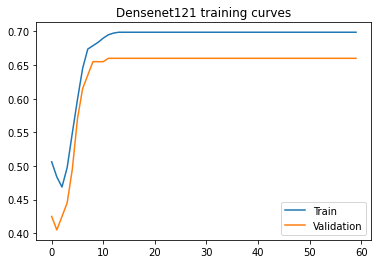

In [ ]:
plt.plot(models['base_model0'].history.history['accuracy'])
plt.plot(models['base_model0'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 26s 725ms/step - loss: 1.7119 - accuracy: 0.1713 - val_loss: 1.0364 - val_accuracy: 0.4800
Epoch 2/60
25/25 [==============================] - 19s 666ms/step - loss: 1.4273 - accuracy: 0.6225 - val_loss: 0.9457 - val_accuracy: 0.4800
Epoch 3/60
25/25 [==============================] - 19s 672ms/step - loss: 1.3202 - accuracy: 0.7025 - val_loss: 0.8956 - val_accuracy: 0.5050
Epoch 4/60
25/25 [==============================] - 19s 672ms/step - loss: 1.2299 - accuracy: 0.7150 - val_loss: 0.8390 - val_accuracy: 0.6000
Epoch 5/60
25/25 [==============================] - 19s 670ms/step - loss: 1.1615 - accuracy: 0.7675 - val_loss: 0.7935 - val_accuracy: 0.7100
Epoch 6/60
25/25 [==============================] - 20s 678ms/step - loss: 1.1069 - accuracy: 0.7487 - val_loss: 0.7573 - val_accuracy: 0.7400
Epoch 7/60
25/25 [==============================] - 20s 696ms/step - loss: 1.0593 - accuracy: 0.7688 - val_loss: 0.7241 - val_accuracy: 0.7800

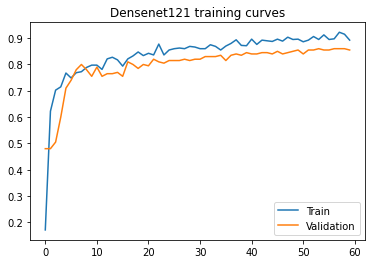

In [ ]:
models['base_model1'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model1'].history.history['accuracy'])
plt.plot(models['base_model1'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 26s 749ms/step - loss: 1.5878 - accuracy: 0.4700 - val_loss: 1.0058 - val_accuracy: 0.5250
Epoch 2/60
25/25 [==============================] - 20s 705ms/step - loss: 1.2435 - accuracy: 0.6712 - val_loss: 0.9363 - val_accuracy: 0.5350
Epoch 3/60
25/25 [==============================] - 20s 693ms/step - loss: 1.0797 - accuracy: 0.7375 - val_loss: 0.8861 - val_accuracy: 0.5700
Epoch 4/60
25/25 [==============================] - 20s 688ms/step - loss: 0.9722 - accuracy: 0.8225 - val_loss: 0.8138 - val_accuracy: 0.6200
Epoch 5/60
25/25 [==============================] - 20s 692ms/step - loss: 0.8983 - accuracy: 0.8275 - val_loss: 0.7771 - val_accuracy: 0.6350
Epoch 6/60
25/25 [==============================] - 20s 697ms/step - loss: 0.8407 - accuracy: 0.8712 - val_loss: 0.6961 - val_accuracy: 0.7050
Epoch 7/60
25/25 [==============================] - 20s 696ms/step - loss: 0.7777 - accuracy: 0.8838 - val_loss: 0.6523 - val_accuracy: 0.7600

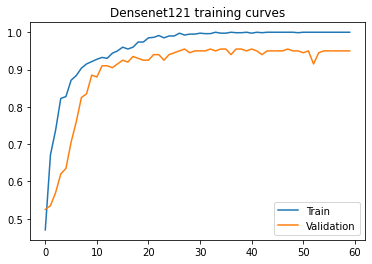

In [ ]:
models['base_model2'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model2'].history.history['accuracy'])
plt.plot(models['base_model2'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 27s 748ms/step - loss: 1.4042 - accuracy: 0.6075 - val_loss: 0.9806 - val_accuracy: 0.4450
Epoch 2/60
25/25 [==============================] - 19s 670ms/step - loss: 1.0096 - accuracy: 0.7300 - val_loss: 0.8120 - val_accuracy: 0.7800
Epoch 3/60
25/25 [==============================] - 20s 676ms/step - loss: 0.8557 - accuracy: 0.8112 - val_loss: 0.7032 - val_accuracy: 0.8850
Epoch 4/60
25/25 [==============================] - 20s 679ms/step - loss: 0.7629 - accuracy: 0.8500 - val_loss: 0.6343 - val_accuracy: 0.8550
Epoch 5/60
25/25 [==============================] - 20s 682ms/step - loss: 0.6641 - accuracy: 0.8888 - val_loss: 0.5949 - val_accuracy: 0.8250
Epoch 6/60
25/25 [==============================] - 20s 684ms/step - loss: 0.6311 - accuracy: 0.8875 - val_loss: 0.5288 - val_accuracy: 0.8450
Epoch 7/60
25/25 [==============================] - 20s 687ms/step - loss: 0.5535 - accuracy: 0.9300 - val_loss: 0.4812 - val_accuracy: 0.8800

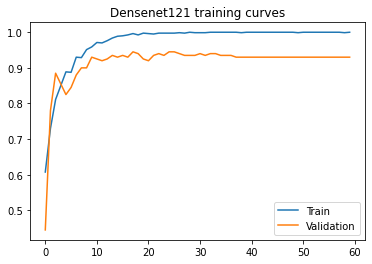

In [ ]:
models['base_model3'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model3'].history.history['accuracy'])
plt.plot(models['base_model3'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 26s 757ms/step - loss: 1.4873 - accuracy: 0.3938 - val_loss: 0.9167 - val_accuracy: 0.5550
Epoch 2/60
25/25 [==============================] - 20s 676ms/step - loss: 0.9976 - accuracy: 0.7800 - val_loss: 0.7419 - val_accuracy: 0.8650
Epoch 3/60
25/25 [==============================] - 20s 683ms/step - loss: 0.8224 - accuracy: 0.8275 - val_loss: 0.6450 - val_accuracy: 0.8550
Epoch 4/60
25/25 [==============================] - 20s 684ms/step - loss: 0.7303 - accuracy: 0.8975 - val_loss: 0.5891 - val_accuracy: 0.8500
Epoch 5/60
25/25 [==============================] - 20s 685ms/step - loss: 0.6431 - accuracy: 0.9000 - val_loss: 0.5335 - val_accuracy: 0.8550
Epoch 6/60
25/25 [==============================] - 20s 689ms/step - loss: 0.5710 - accuracy: 0.9200 - val_loss: 0.4953 - val_accuracy: 0.8700
Epoch 7/60
25/25 [==============================] - 20s 687ms/step - loss: 0.5453 - accuracy: 0.9013 - val_loss: 0.4494 - val_accuracy: 0.8700

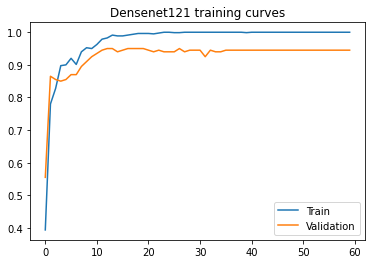

In [ ]:
models['base_model4'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model4'].history.history['accuracy'])
plt.plot(models['base_model4'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

In [ ]:
models['base_model5'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model5'].history.history['accuracy'])
plt.plot(models['base_model5'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 27s 785ms/step - loss: 1.5130 - accuracy: 0.7462 - val_loss: 1.1275 - val_accuracy: 0.4350
Epoch 2/60
25/25 [==============================] - 20s 690ms/step - loss: 0.8869 - accuracy: 0.7975 - val_loss: 0.8481 - val_accuracy: 0.5450
Epoch 3/60
25/25 [==============================] - 20s 683ms/step - loss: 0.7341 - accuracy: 0.8263 - val_loss: 0.6402 - val_accuracy: 0.8600
Epoch 4/60
25/25 [==============================] - 20s 687ms/step - loss: 0.6443 - accuracy: 0.8625 - val_loss: 0.5334 - val_accuracy: 0.8750
Epoch 5/60
25/25 [==============================] - 20s 692ms/step - loss: 0.5868 - accuracy: 0.8963 - val_loss: 0.4762 - val_accuracy: 0.8900
Epoch 6/60
25/25 [==============================] - 20s 691ms/step - loss: 0.5121 - accuracy: 0.8975 - val_loss: 0.4095 - val_accuracy: 0.9000
Epoch 7/60
25/25 [==============================] - 20s 694ms/step - loss: 0.4604 - accuracy: 0.9275 - val_loss: 0.3959 - val_accuracy: 0.9200

Epoch 1/60
25/25 [==============================] - 149s 4s/step - loss: 1.2353 - accuracy: 0.4988 - val_loss: 1.1311 - val_accuracy: 0.5150
Epoch 2/60
25/25 [==============================] - 10s 352ms/step - loss: 0.7702 - accuracy: 0.8450 - val_loss: 0.9862 - val_accuracy: 0.5200
Epoch 3/60
25/25 [==============================] - 10s 352ms/step - loss: 0.6222 - accuracy: 0.8963 - val_loss: 0.8979 - val_accuracy: 0.5300
Epoch 4/60
25/25 [==============================] - 10s 350ms/step - loss: 0.5086 - accuracy: 0.9062 - val_loss: 0.8165 - val_accuracy: 0.5550
Epoch 5/60
25/25 [==============================] - 10s 351ms/step - loss: 0.4482 - accuracy: 0.9312 - val_loss: 0.7246 - val_accuracy: 0.6050
Epoch 6/60
25/25 [==============================] - 10s 350ms/step - loss: 0.3843 - accuracy: 0.9438 - val_loss: 0.6566 - val_accuracy: 0.6450
Epoch 7/60
25/25 [==============================] - 10s 351ms/step - loss: 0.3352 - accuracy: 0.9513 - val_loss: 0.5361 - val_accuracy: 0.7700
E

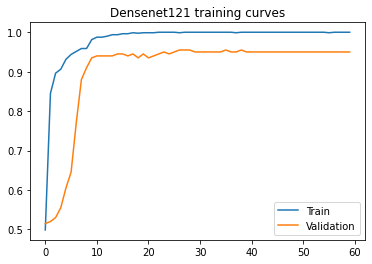

In [ ]:
models['base_model6'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model6'].history.history['accuracy'])
plt.plot(models['base_model6'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 17s 413ms/step - loss: 1.3023 - accuracy: 0.5800 - val_loss: 1.2842 - val_accuracy: 0.0950
Epoch 2/60
25/25 [==============================] - 10s 352ms/step - loss: 0.7704 - accuracy: 0.8025 - val_loss: 0.8982 - val_accuracy: 0.5800
Epoch 3/60
25/25 [==============================] - 10s 355ms/step - loss: 0.6331 - accuracy: 0.8813 - val_loss: 0.7028 - val_accuracy: 0.7350
Epoch 4/60
25/25 [==============================] - 10s 355ms/step - loss: 0.5418 - accuracy: 0.9013 - val_loss: 0.6009 - val_accuracy: 0.7750
Epoch 5/60
25/25 [==============================] - 10s 352ms/step - loss: 0.4674 - accuracy: 0.9187 - val_loss: 0.5260 - val_accuracy: 0.8200
Epoch 6/60
25/25 [==============================] - 10s 355ms/step - loss: 0.4186 - accuracy: 0.9275 - val_loss: 0.4487 - val_accuracy: 0.8750
Epoch 7/60
25/25 [==============================] - 10s 350ms/step - loss: 0.3768 - accuracy: 0.9375 - val_loss: 0.4216 - val_accuracy: 0.8550

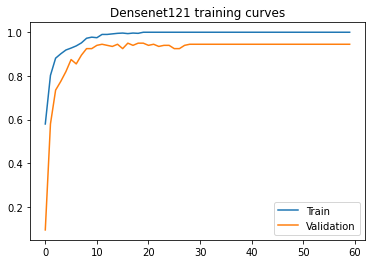

In [ ]:
models['base_model7'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model7'].history.history['accuracy'])
plt.plot(models['base_model7'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 17s 412ms/step - loss: 1.2230 - accuracy: 0.7362 - val_loss: 0.7985 - val_accuracy: 0.5000
Epoch 2/60
25/25 [==============================] - 10s 355ms/step - loss: 0.7163 - accuracy: 0.8350 - val_loss: 0.6222 - val_accuracy: 0.8650
Epoch 3/60
25/25 [==============================] - 10s 353ms/step - loss: 0.5722 - accuracy: 0.8825 - val_loss: 0.5345 - val_accuracy: 0.8900
Epoch 4/60
25/25 [==============================] - 10s 353ms/step - loss: 0.4788 - accuracy: 0.9200 - val_loss: 0.4662 - val_accuracy: 0.9050
Epoch 5/60
25/25 [==============================] - 10s 356ms/step - loss: 0.4124 - accuracy: 0.9388 - val_loss: 0.4184 - val_accuracy: 0.9150
Epoch 6/60
25/25 [==============================] - 10s 354ms/step - loss: 0.3536 - accuracy: 0.9413 - val_loss: 0.3582 - val_accuracy: 0.9200
Epoch 7/60
25/25 [==============================] - 10s 353ms/step - loss: 0.2901 - accuracy: 0.9638 - val_loss: 0.3313 - val_accuracy: 0.9100

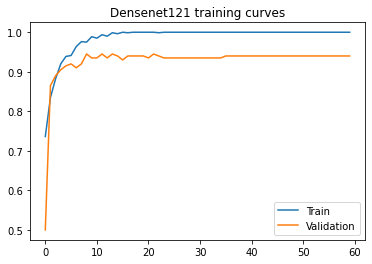

In [ ]:
models['base_model8'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model8'].history.history['accuracy'])
plt.plot(models['base_model8'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

Epoch 1/60
25/25 [==============================] - 17s 418ms/step - loss: 1.0989 - accuracy: 0.6275 - val_loss: 0.9139 - val_accuracy: 0.5600
Epoch 2/60
25/25 [==============================] - 10s 357ms/step - loss: 0.6480 - accuracy: 0.8450 - val_loss: 0.7043 - val_accuracy: 0.7200
Epoch 3/60
25/25 [==============================] - 10s 354ms/step - loss: 0.5084 - accuracy: 0.9075 - val_loss: 0.6038 - val_accuracy: 0.7850
Epoch 4/60
25/25 [==============================] - 10s 358ms/step - loss: 0.4238 - accuracy: 0.9237 - val_loss: 0.5194 - val_accuracy: 0.8350
Epoch 5/60
25/25 [==============================] - 10s 355ms/step - loss: 0.3193 - accuracy: 0.9488 - val_loss: 0.4419 - val_accuracy: 0.8600
Epoch 6/60
25/25 [==============================] - 10s 355ms/step - loss: 0.2844 - accuracy: 0.9625 - val_loss: 0.3886 - val_accuracy: 0.8950
Epoch 7/60
25/25 [==============================] - 10s 356ms/step - loss: 0.2187 - accuracy: 0.9625 - val_loss: 0.3135 - val_accuracy: 0.9100

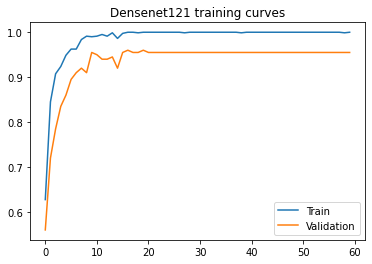

In [ ]:
models['base_model9'].fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = [reduce_lr])
plt.plot(models['base_model9'].history.history['accuracy'])
plt.plot(models['base_model9'].history.history['val_accuracy'])
plt.legend(['Train', 'Validation'])
plt.title('Densenet121 training curves')
plt.show()

In [ ]:
test_model = models['base_model9']

In [ ]:
i=0
for model_name, model in models.items():
    trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    totalParams = trainableParams + nonTrainableParams
    
    print('base_model'+str(i),trainableParams,nonTrainableParams,totalParams)
    i+=1


base_model0 3075 7037504 7040579
base_model1 41987 6998592 7040579
base_model2 171203 6869376 7040579
base_model3 331203 6709376 7040579
base_model4 369987 6670592 7040579
base_model5 490883 6549696 7040579
base_model6 642691 6397888 7040579
base_model7 681603 6358976 7040579
base_model8 830787 6209792 7040579
base_model9 939203 6101376 7040579
